## Script Engine Performance Test

Two JS engines were compared: Rhino and Nashorn. These tests were used: [dromaeo](http://dromaeo.com/?dromaeo) 

Before measure perofrmance 20 warm up iterations were executed to allow JIT make some optimizations. 

**System Configuration**:

OS: Ubuntu 18.04<br>

Processor: Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz x 4<br>

RAM: 8 GB

Java:<br>

`java version "1.8.0_171"
Java(TM) SE Runtime Environment (build 1.8.0_171-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)`

In [1]:
# imports
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
# input params
result_folder = '../../data/common-hotspot'
warmup_subfolder = '/warmup'
result_subfolder = '/results'

warm_up_count = 20
warm_up_graph_columns = 2

engine_cases = ['nashorn', 'rhino']

In [3]:
data = {}


def load_test_res(path):
    res = []
    tests = json.load(open(path))
    
    for i, test in enumerate(tests):
        local = {
            'name': test['name'], 
            'samples': 1 / np.array(test['stats']['sample']),
            'speed_error': test['speed'] * test['stats']['rme'] / 100, 
            'speed': test['speed']
        }
        res.append(local)
    return res

    
def load_test_results(engine):
    res = [
        load_test_res(
            result_folder + result_subfolder + 
                '/' + engine + '/results.out'
        )
    ]
    for i in range(0, warm_up_count):
        res.append(
            load_test_res(
                result_folder + warmup_subfolder + '/' + engine + 
                    '/results-iter' + str(i) + '.out'
            )
        )
    data[engine] = res

In [4]:
for engine in engine_cases:
    load_test_results(engine)

In [5]:
%matplotlib inline

def prepare_warm_up_test(test_number):
    result = {
        engine: {
            'speed': [
                iteration[test_number]['speed'] 
                for i, iteration in enumerate(data[engine]) 
                if i > 0
            ],
            'speed_error': [
                iteration[test_number]['speed_error'] 
                for i, iteration in enumerate(data[engine]) 
                if i > 0
            ]
        } for engine in engine_cases
    }
    result['name'] = data['nashorn'][1][test_number]['name']
    return result


def warm_up_tests_count():
    return len(data['nashorn'][1])


def draw_warm_up_tests():
    columns_number = warm_up_graph_columns
    rows_number = math.ceil(warm_up_tests_count() / columns_number)
    
    fig, axes = plt.subplots(
        nrows=rows_number, 
        ncols=columns_number, 
        figsize=(15, 50)
    )
    plt.subplots_adjust(bottom=0.1, right=0.8)
    plt.suptitle('Warm Up iterations', fontsize=16, y=0.9)
    
    for row in range(0, rows_number):
        for column in range(0, columns_number):
            graph_data = prepare_warm_up_test(row * columns_number + column)
            x = np.arange(warm_up_count)
            
            for engine in engine_cases:
                axes[row, column].errorbar(
                    x, graph_data[engine]['speed'],
                    graph_data[engine]['speed_error'], 
                    capsize=5, elinewidth=2, 
                    markeredgewidth=2, label=engine, 
                    marker='.'
                )
            
            axes[row, column].xaxis.set_major_locator(MaxNLocator(integer=True))
            axes[row, column].set_title('Warm up: ' + graph_data['name'])
            axes[row, column].legend()
            axes[row, column].set_ylabel("Speed, op/sec")
            axes[row, column].set_xlabel("Iteration")
            axes[row, column].set_xlim(xmax=warm_up_count)
    plt.show()


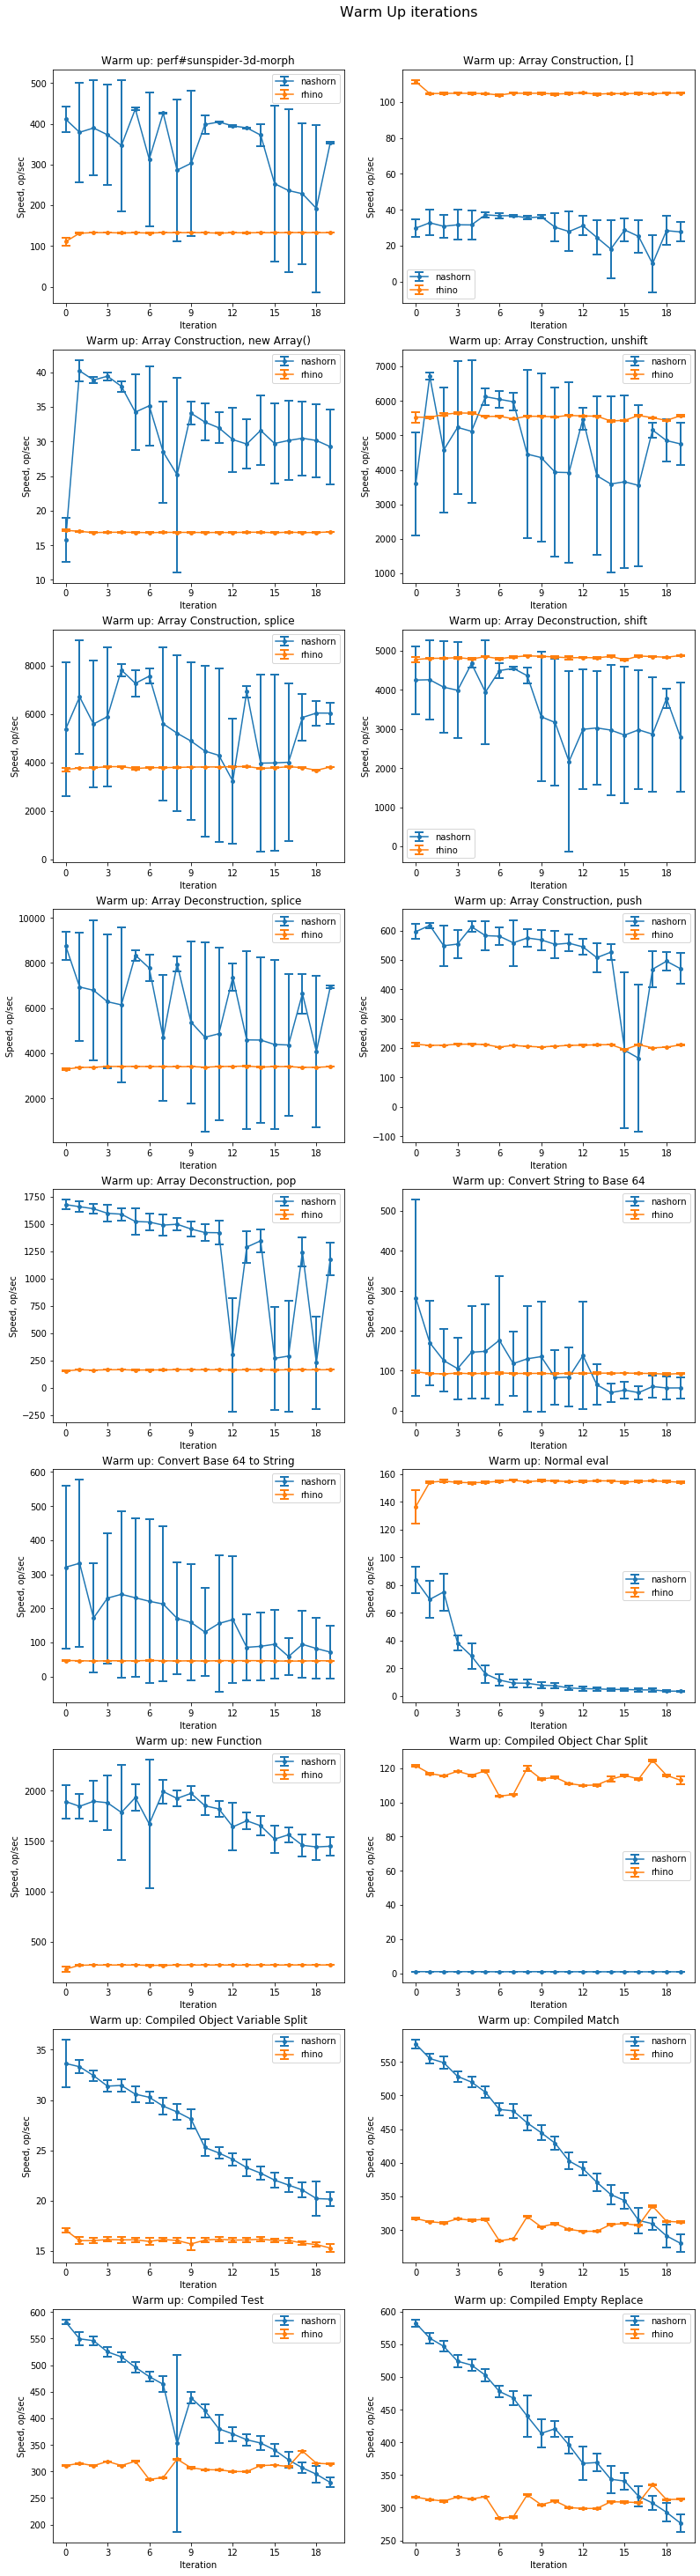

In [6]:
draw_warm_up_tests()

In [7]:
def prepare_final_test():
    result = {
        engine + '_values': [test['speed'] for test in data[engine][0]]
        for engine in engine_cases
    }
    for engine in engine_cases:
        result[engine + '_over_rhino'] = \
            np.array(result[engine + '_values']) / np.array(result['rhino_values'])
    result['names'] = [test['name'] for test in data['nashorn'][0]]
    return result

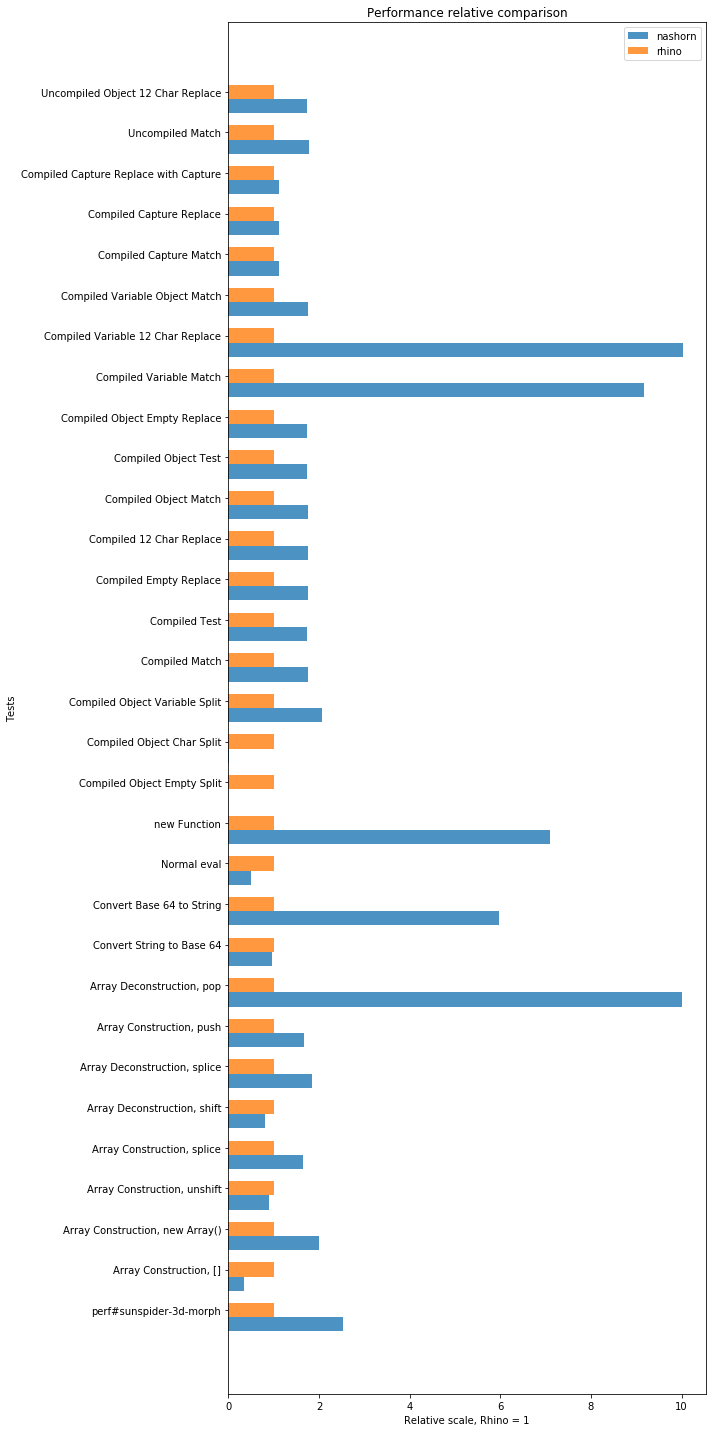

In [8]:
final_test_data = prepare_final_test()    
# data to plot
n_groups = len(final_test_data['names'])
 
# create plot
fig, ax = plt.subplots(figsize=(10, 20))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, engine in enumerate(engine_cases):
    plt.barh(
        index + i * bar_width, 
        final_test_data[engine + '_over_rhino'], 
        bar_width,
        alpha=opacity, label=engine
    )
 
plt.ylabel('Tests')
plt.xlabel('Relative scale, Rhino = 1')
plt.title('Performance relative comparison')
plt.yticks(index + bar_width, final_test_data['names'])
plt.legend()
 
plt.tight_layout()
plt.show()